In [1]:
import numpy as np
import matplotlib.pyplot as plt


from __future__ import print_function 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit 


In [3]:
# Frequency differences in MHZ between the 87 and 85 transitions, for the GS
f_87D2 = 384230484
f_85D2 = 384230406
f_87F1_rel = +4272
f_87F2_rel = -2563
f_85F2_rel = +1771
f_85F3_rel = -1265
df_87_F1 = f_87D2 + f_87F1_rel
df_87_F2 = f_87D2 + f_87F2_rel
df_85_F2 = f_85D2 + f_85F2_rel
df_85_F3 = f_85D2 + f_85F3_rel

# laser frequency, putting the zero to the resonance with 87_F1
fL_87_F1 = df_87_F1 - df_87_F1
fL_87_F2 = df_87_F2 - df_87_F1
fL_85_F2 = df_85_F2 - df_87_F1
fL_85_F3 = df_85_F3 - df_87_F1

# array of the relative laser frequencies from the smallest to the largest
fl_array = np.array([fL_87_F1,fL_85_F2,fL_85_F3,fL_87_F2])

[    0 -2579 -5615 -6835]


In [72]:
# Gaussian functions for the fitting of the doppler-broadened lines
def Gauss(x, A, D,x0): 
    y = A*np.exp(-(x-x0)**2/(2*D**2)) 
    return y 

# Lorentzian function with amplitude A, width D, and center x0
def Lor(x,x0,D,A):
    return A/(1+(x-x0)**2/D**2)

# Fitting function for 6 SAS peaks, with a gaussian envelope
def SAS_fit_6(x,x1,D1,A1,x2,D2,A2,x3,D3,A3,x4,D4,A4,x5,D5,A5,x6,D6,A6,x0G,DG):
    'x is the independent variable, x0G, DG are the center and width of the Gaussian envelope, the rest are the parameters for the 6 Lorentzian peaks.'
    v = 0
    v += Lor(x,x1,D1,A1)
    v += Lor(x,x2,D2,A2)
    v += Lor(x,x3,D3,A3)
    v += Lor(x,x4,D4,A4)
    v += Lor(x,x5,D5,A5)
    v += Lor(x,x6,D6,A6)
    v *= np.exp(-(x-x0G)**2/(2*DG**2))
    return v

def get_centers_6(params):
    'returns the centers of the 6 peaks'
    return np.array([params[0],params[3],params[6],params[9],params[12],params[15]])

def get_widths_6(params):
    'returns the widths of the 6 peaks'
    return np.array([params[1],params[4],params[7],params[10],params[13],params[16]])

In [116]:
# this function finds where the voltage ramp of the function generator starts and ends averaging out the signal and finding the max 

def find_extremes_ramp(x):
    t = np.arange(0,len(x))
    step = 5 # take the average every 5 points
    width = 25 # width of the averaging window
    l_d = int((len(x)-width)/step)+1
    pos_arr = np.zeros(l_d)
    avg_arr = np.zeros(l_d)
    for i in range(l_d):
        pos_arr[i] = i*step + width/2
        avg_arr[i] = np.mean(x[i*step:i*step+width])
    start = pos_arr[np.argmin(avg_arr)]
    end = pos_arr[np.argmax(avg_arr)]
    # if the start is after the end, swap them
    if start > end:
        start,end = end,start
    return int(start),int(end)

# this function identifies the regions where the spectroscopy signal is linear (ie far from the resonances) with the second derivative of the signal

def find_where_linear(x, ax):
    t = np.arange(0,len(x))
    step = 10  # take the average every 10 points
    width = 40 # width of the fitting window
    l_dd = int((len(x)-width)/step)+1
    dd_arr = np.zeros(l_dd)
    pos_arr = np.zeros(l_dd)
    for i in range(l_dd):
        pfit = np.polyfit(t[i*step:i*step+width],x[i*step:i*step+width],2) # fit a second order polynomial
        dd_arr[i] = pfit[0] # the second derivative is the first coefficient of the polynomial
        pos_arr[i] = i*step + width/2
    lim = np.amax(abs(dd_arr))/15 # IMPORTANT threshold for the second derivative to be basically considered 0, can be adjusted if needed

    # plot the second derivative and the threshold, useful for adjusting the threshold
    ax.plot(pos_arr,abs(dd_arr))
    ax.axhline(y=lim, color='r', linestyle='-')
    ax.set_title('Second derivative, linear finding')
    
    # take the regions where the second derivative is below the threshold for at least a fixed number of points (avoiding noise)
    thr_points = 5 # IMPORTANT minimum number of points below the threshold, can be adjusted if needed
    dd_arr = abs(dd_arr)
    dd_arr[dd_arr<lim] = 0
    starts = np.zeros(4)
    ends = np.zeros(4)
    idx = 0
    running = False
    for i in range(len(dd_arr)-1):
        if (dd_arr[i] == 0) and (running == False):
            starts[idx] = pos_arr[i]
            running = True
            cnt = 1
        if (dd_arr[i] == 0) and (running == True):
            cnt += 1
        if (dd_arr[i] != 0) and (running == True):
            if cnt > thr_points:
                ends[idx] = pos_arr[i]
                idx += 1
                running = False
            if cnt<thr_points:
                running = False
    ends[-1] = pos_arr[-1]
    return starts,ends



In [32]:
# takes a file with the data in columns of t,signal,FG and saves in arrays

def read_file(filename):
    data = np.loadtxt(filename,skiprows=2,delimiter=",",dtype=str)
    t = data[:,0].astype(float)
    V_pd = data[:,1].astype(float)
    V_fg = data[:,2].astype(float)
    return t,V_pd,V_fg

# Rb87, Fg=2 Line

In [66]:
# we save all frequencies from the p line center

f_Rb87_Fe0 = - 302.074
f_Rb87_Fe1 = - 229.852
f_Rb87_Fe2 = - 72.911
f_Rb87_Fe3 = + 193.741
f_Rb87_CO_01 = (f_Rb87_Fe0 + f_Rb87_Fe1)/2
f_Rb87_CO_12 = (f_Rb87_Fe1 + f_Rb87_Fe2)/2
f_Rb87_CO_23 = (f_Rb87_Fe2 + f_Rb87_Fe3)/2
f_Rb87_CO_13 = (f_Rb87_Fe0 + f_Rb87_Fe3)/2
f_Rb87_CO_02 = (f_Rb87_Fe0 + f_Rb87_Fe2)/2
f_Rb87_CO_03 = (f_Rb87_Fe1 + f_Rb87_Fe3)/2

Text(0.5, 1.0, 'Clipped and offsetted DF AC')

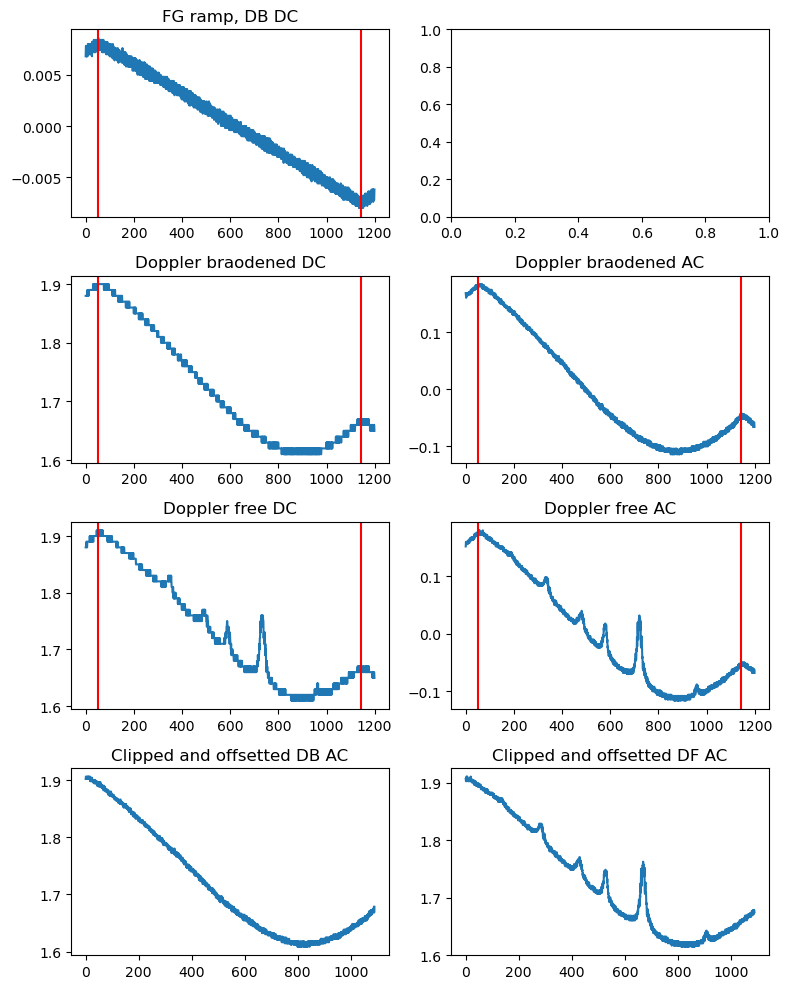

In [53]:
fig, ax = plt.subplots(4, 2, figsize=(8, 10), tight_layout=True)

# get the four files with the data
t_DB_DC,V_pd_DB_DC,V_fg_DB_DC = read_file("/media/jacklook/JL_USB/NewFile20.csv")
t_DB_AC, V_pd_DB_AC, V_fg_DB_AC = read_file("/media/jacklook/JL_USB/NewFile21.csv")
t_DF_DC, V_pd_DF_DC, V_fg_DF_DC = read_file("/media/jacklook/JL_USB/NewFile19.csv")
t_DF_AC, V_pd_DF_AC, V_fg_DF_AC = read_file("/media/jacklook/JL_USB/NewFile18.csv")

# I now find the extremes of the voltage ramp for the function generator
start,end = find_extremes_ramp(V_fg_DB_DC)
ax[0,0].plot(V_fg_DB_DC)
ax[0,0].set_title("FG ramp, DB DC")
ax[0,0].axvline(x=start, color='r', linestyle='-')
ax[0,0].axvline(x=end, color='r', linestyle='-')

# I now take the AC data, correct the DC offset and clip them
V_pd_DB_AC_c = V_pd_DB_AC - np.mean(V_pd_DB_AC) + np.mean(V_pd_DB_DC)
V_pd_DB_AC_c = V_pd_DB_AC_c[start:end]
V_pd_DF_AC_c = V_pd_DF_AC - np.mean(V_pd_DF_AC) + np.mean(V_pd_DF_DC)
V_pd_DF_AC_c = V_pd_DF_AC_c[start:end]

# plot everything to see the files are correct

ax[1,0].plot(t_DB_DC,V_pd_DB_DC)
ax[1,0].axvline(x=start, color='r', linestyle='-')
ax[1,0].axvline(x=end, color='r', linestyle='-')
ax[1,0].set_title("Doppler braodened DC")
ax[1,1].plot(t_DB_AC,V_pd_DB_AC)
ax[1,1].axvline(x=start, color='r', linestyle='-')
ax[1,1].axvline(x=end, color='r', linestyle='-')
ax[1,1].set_title("Doppler braodened AC")
ax[2,0].plot(t_DF_DC,V_pd_DF_DC)
ax[2,0].axvline(x=start, color='r', linestyle='-')
ax[2,0].axvline(x=end, color='r', linestyle='-')
ax[2,0].set_title("Doppler free DC")
ax[2,1].plot(t_DF_AC,V_pd_DF_AC)
ax[2,1].axvline(x=start, color='r', linestyle='-')
ax[2,1].axvline(x=end, color='r', linestyle='-')
ax[2,1].set_title("Doppler free AC")

ax[3,0].plot(V_pd_DB_AC_c)
ax[3,0].set_title("Clipped and offsetted DB AC")
ax[3,1].plot(V_pd_DF_AC_c)
ax[3,1].set_title("Clipped and offsetted DF AC")



Widths:  [28.45958868  6.1062959   7.36637206  5.06193008  6.39115573  2.96641457]


Text(0, 0.5, 'Center (px)')

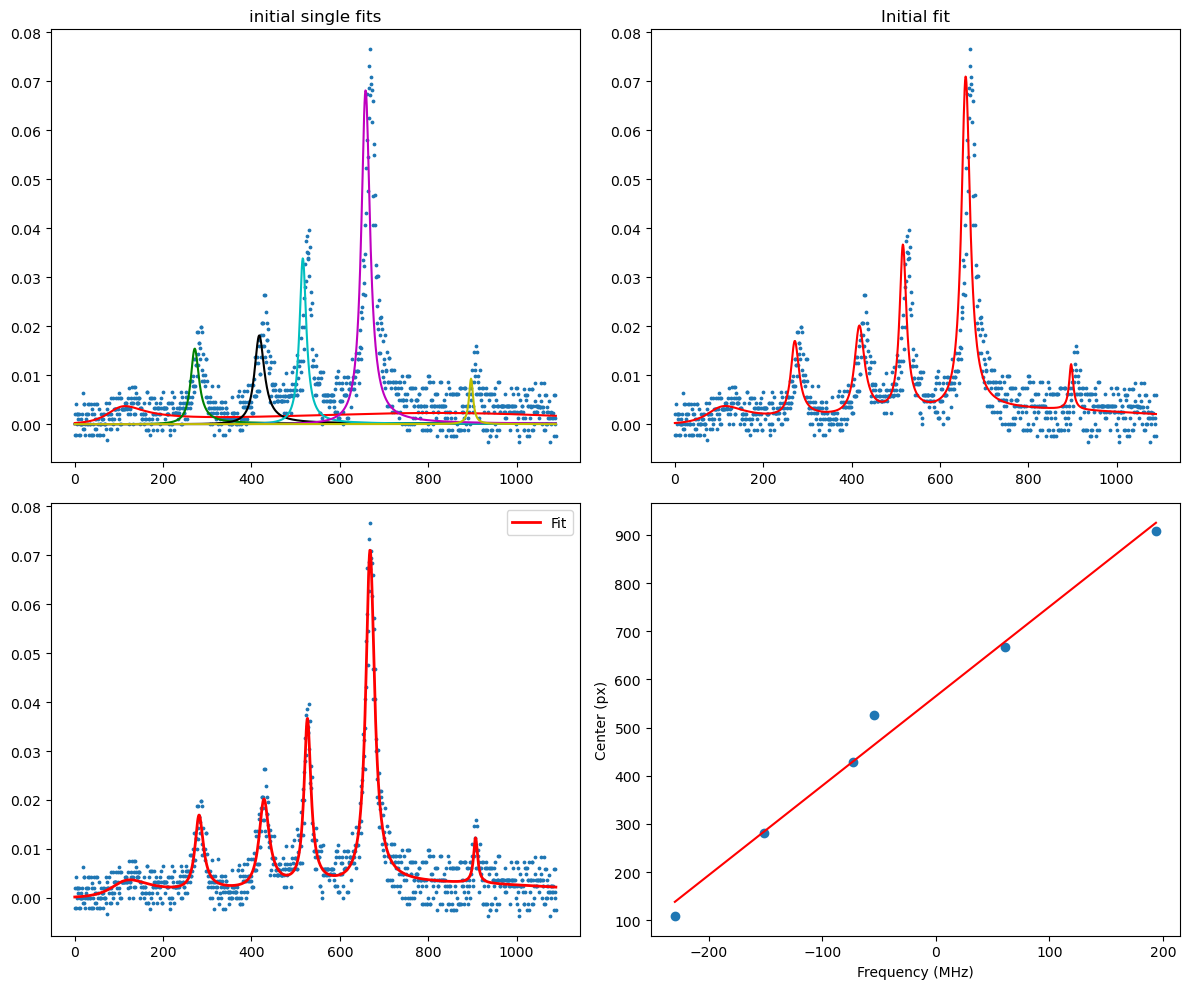

In [100]:
fig,ax = plt.subplots(2,2,figsize=(12,10),tight_layout=True)

# I now compute the absorption signal
K_sg = np.log(V_pd_DF_AC_c/V_pd_DB_AC_c)
x = np.arange(len(K_sg))


# array of six colours
colors = ['r','g','k','c','m','y']

lor_1 = np.array([99,51.23,0.639])
lor_2 = np.array([271,11.35,0.529])
lor_3 = np.array([417,13.6,0.191])
lor_4 = np.array([516,9.39,0.184])
lor_5 = np.array([658,11.87,0.173])
lor_6 = np.array([897,5.54,0.0109])
lor_s = np.array([lor_1,lor_2,lor_3,lor_4,lor_5,lor_6])
gauss = np.array([1066,298.9,0.01])

ax[0,0].scatter(x,K_sg,s=3)
for i in range(6):
    #ax[0,0].axhline(y=lor_s[i,2]*np.exp(-(lor_s[i,0]-gauss[0])**2/2/gauss[1]**2), color=colors[i], linestyle='-')
    #ax[0,0].axvline(x=lor_s[i,0], color=colors[i], linestyle='-')
    #ax[0,0].axvspan(lor_s[i,0]-lor_s[i,1],lor_s[i,0]+lor_s[i,1], alpha=0.2, color=colors[i])
    ax[0,0].plot(x,Lor(x,lor_s[i,0],lor_s[i,1],lor_s[i,2])*np.exp(-(x-gauss[0])**2/2/gauss[1]**2),color=colors[i])

ax[0,0].set_title("initial single fits")

p0 = [lor_1[0],lor_1[1],lor_1[2],lor_2[0],lor_2[1],lor_2[2],lor_3[0],lor_3[1],lor_3[2],lor_4[0],lor_4[1],lor_4[2],lor_5[0],lor_5[1],lor_5[2],lor_6[0],lor_6[1],lor_6[2],gauss[0],gauss[1]]

# get the fit with the initial parameters
fit_0 = SAS_fit_6(x,*p0)

ax[0,1].scatter(x,K_sg,s=3)
ax[0,1].plot(x,fit_0,color='r',label='Initial fit')
ax[0,1].set_title("Initial fit")

popt, pcov = curve_fit(SAS_fit_6, x, K_sg, p0)
ax[1,0].scatter(x,K_sg,s=3)
ax[1,0].plot(x,SAS_fit_6(x,*popt),lw=2,c='r',label='Fit')
ax[1,0].legend()

fs = np.array([f_Rb87_Fe1,f_Rb87_CO_12,f_Rb87_Fe2,f_Rb87_CO_13,f_Rb87_CO_23,f_Rb87_Fe3])
centers = get_centers_6(popt)
ind = np.argsort(centers)
centers = centers[ind]
lin = np.polyfit(fs,centers,1)
ax[1,1].scatter(fs,centers)
ax[1,1].plot(fs,lin[0]*fs+lin[1],c='r',label='Linear fit')
print("Widths: ",get_widths_6(popt)[ind]/lin[0])
ax[1,1].set_xlabel("Frequency (MHz)")
ax[1,1].set_ylabel("Center (px)")



# Doppler-broadened spectroscopy

Text(0.5, 1.0, 'Rescaled absorption signal')

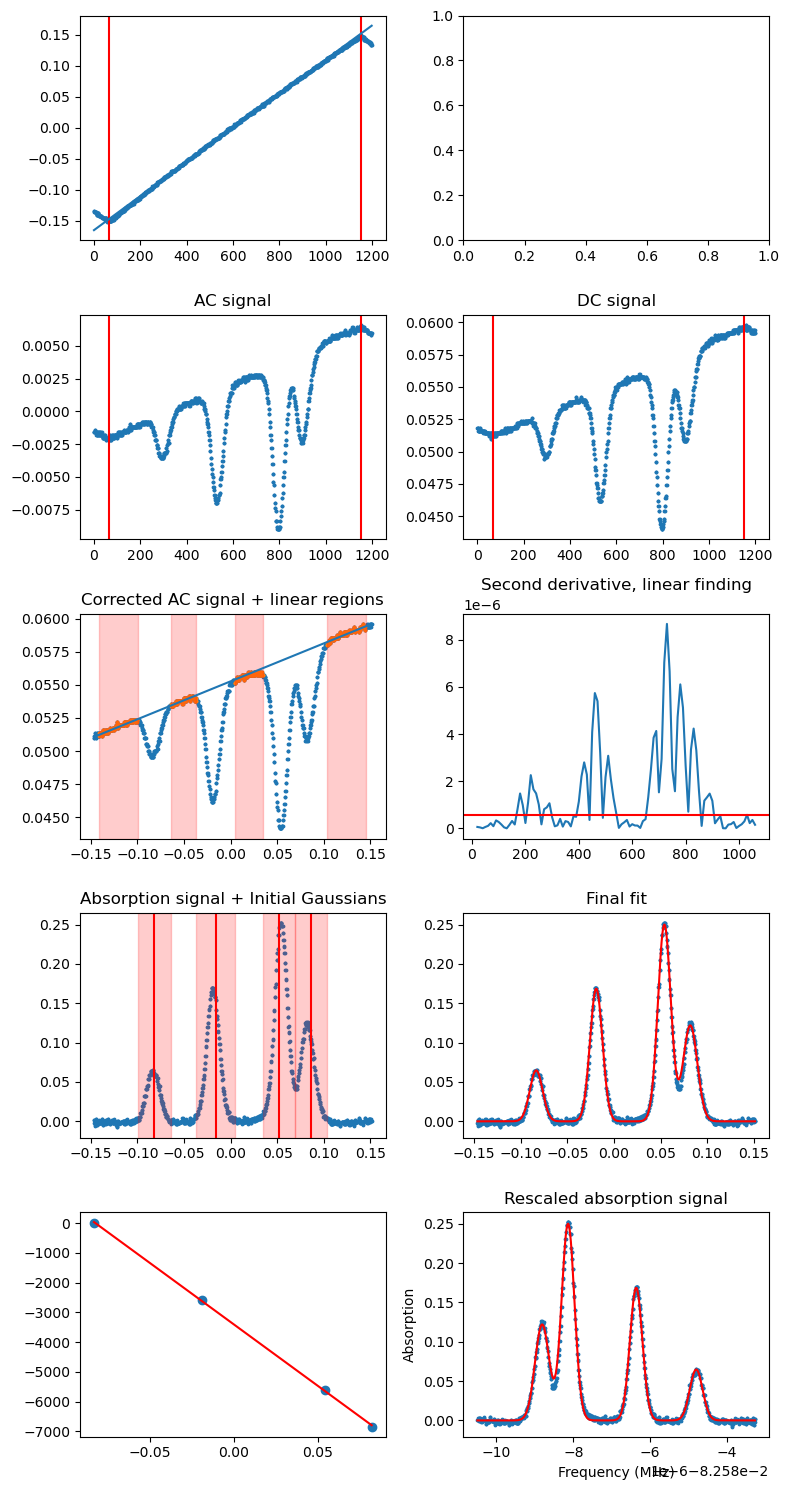

In [129]:
fig,ax = plt.subplots(5,2,figsize=(8,15),tight_layout=True)

# load the data
t_DC,V_fg_DC,V_pd_DC = read_file("/media/jacklook/JL_USB/NewFile13.csv")
t_AC,V_fg_AC,V_pd_AC = read_file("/media/jacklook/JL_USB/NewFile12.csv")

# find the extremes of the voltage ramp
start,end = find_extremes_ramp(V_fg_DC)

# linearize the FG signal
Vf_vs_t_linfit = np.polyfit(t_DC[start:end],V_fg_DC[start:end],1)
Vf_vs_t_a = Vf_vs_t_linfit[0]
Vf_vs_t_b = Vf_vs_t_linfit[1]
Vf_better = Vf_vs_t_a*t_DC+Vf_vs_t_b

ax[0,0].scatter(t_DC,V_fg_DC,s=3)
ax[0,0].axvline(x=start, color='r', linestyle='-')
ax[0,0].axvline(x=end, color='r', linestyle='-')
ax[0,0].plot(t_DC,t_DC*Vf_vs_t_a+Vf_vs_t_b,label='linear fit')

ax[1,0].scatter(t_AC,V_pd_AC,s=3)
ax[1,0].axvline(x=start, color='r', linestyle='-')
ax[1,0].axvline(x=end, color='r', linestyle='-')
ax[1,0].set_title("AC signal")
ax[1,1].scatter(t_DC,V_pd_DC,s=3)
ax[1,1].axvline(x=start, color='r', linestyle='-')
ax[1,1].axvline(x=end, color='r', linestyle='-')
ax[1,1].set_title("DC signal")

# correct the Vfg vs t for clipping
Vf_vs_t_b = Vf_vs_t_a*start+Vf_vs_t_b

# correct the AC signal for the DC offset and clip it
V_pd_AC_c = V_pd_AC - np.mean(V_pd_AC) + np.mean(V_pd_DC)
V_pd_AC_c = V_pd_AC_c[start:end]
Vf_c = Vf_better[start:end]

# find where the signal is linear
starts,ends = find_where_linear(V_pd_AC_c,ax[2,1])

# collect the indexes of the linear regions
lin_indexes = np.arange(int(starts[0]),int(ends[0]))
for i in range(1,4):
    lin_indexes = np.concatenate((lin_indexes,np.arange(int(starts[i]),int(ends[i]))))
lin_indexes = lin_indexes.astype(int)

# fit the linear part of the signal, to find the relation Vfg vs Vpd out of resonance
Vf_lin = Vf_c[lin_indexes]
Vpd_lin = V_pd_AC_c[lin_indexes]
Vpd_vs_Vf_linfit = np.polyfit(Vf_lin,Vpd_lin,1)
Vpd_vs_Vf_a = Vpd_vs_Vf_linfit[0]
Vpd_vs_Vf_b = Vpd_vs_Vf_linfit[1]

# transform regions from t to Vf
starts = starts*Vf_vs_t_a+Vf_vs_t_b
ends = ends*Vf_vs_t_a+Vf_vs_t_b

ax[2,0].scatter(Vf_c,V_pd_AC_c,s=3)
ax[2,0].scatter(Vf_lin,Vpd_lin,s=3)
ax[2,0].plot(Vf_c,Vf_c*Vpd_vs_Vf_a+Vpd_vs_Vf_b,label='linear fit')
for i in range(4):
    ax[2,0].axvspan(starts[i],ends[i], alpha=0.2, color='r')
ax[2,0].set_title("Corrected AC signal + linear regions")

# compute the absorption signal
K_sg = -np.log(V_pd_AC_c/(Vf_c*Vpd_vs_Vf_a+Vpd_vs_Vf_b))

# fit the absorption signal
G_s1 = ends[0]
G_e1 = starts[1]
G_s2 = ends[1]
G_e2 = starts[2]
G_s3 = ends[2]
G_e3 = 0.5*ends[2]+0.5*starts[3]
G_s4 = 0.5*ends[2]+0.5*starts[3]
G_e4 = starts[3]

G_s = np.array([G_s1,G_s2,G_s3,G_s4])
Gs_ind = (G_s-Vf_vs_t_b)/Vf_vs_t_a
G_e = np.array([G_e1,G_e2,G_e3,G_e4])
Ge_ind = (G_e-Vf_vs_t_b)/Vf_vs_t_a
G_c = (G_e+G_s)/2
G_d = np.zeros(4)


ax[3,0].scatter(Vf_c,K_sg,s=3)

for i in range(4):
    ax[3,0].axvspan(G_s[i],G_e[i], alpha=0.2, color='r')
    ax[3,0].axvline(x=G_c[i], color='r', linestyle='-')

ax[3,0].set_title("Absorption signal + Initial Gaussians")

# now fit absorption signal
gauss_tot = np.zeros(len(Vf_c))
for i in range(4):
    popt,pcov = curve_fit(Gauss,Vf_c[int(Gs_ind[i]):int(Ge_ind[i])],K_sg[int(Gs_ind[i]):int(Ge_ind[i])],p0=[0.1,0.1,G_c[i]])
    gauss_tot += Gauss(Vf_c,*popt)
    G_c[i] = popt[2]
    G_d[i] = popt[1]

ax[3,1].plot(Vf_c,gauss_tot,c='r',label='Fit')
ax[3,1].scatter(Vf_c,K_sg,s=3)
ax[3,1].set_title("Final fit")

# now fit frequency vs center
Vf_vs_fl_linfit = np.polyfit(G_c,fl_array,1)
Vf_vs_fl_a = Vf_vs_fl_linfit[0]
Vf_vs_fl_b = Vf_vs_fl_linfit[1]

ax[4,0].scatter(G_c,fl_array)
ax[4,0].plot(G_c,Vf_vs_fl_a*G_c+Vf_vs_fl_b,c='r',label='Fit')

# now rescale absorption signal
fl_vals = (Vf_c-Vf_vs_fl_b)/Vf_vs_fl_a
ax[4,1].plot(fl_vals,gauss_tot,c='r',label='Fit')
ax[4,1].scatter(fl_vals,K_sg,s=3)
ax[4,1].set_xlabel("Frequency (MHz)")
ax[4,1].set_ylabel("Absorption")
ax[4,1].set_title("Rescaled absorption signal")






TypeError: find_where_linear() missing 1 required positional argument: 'ax'

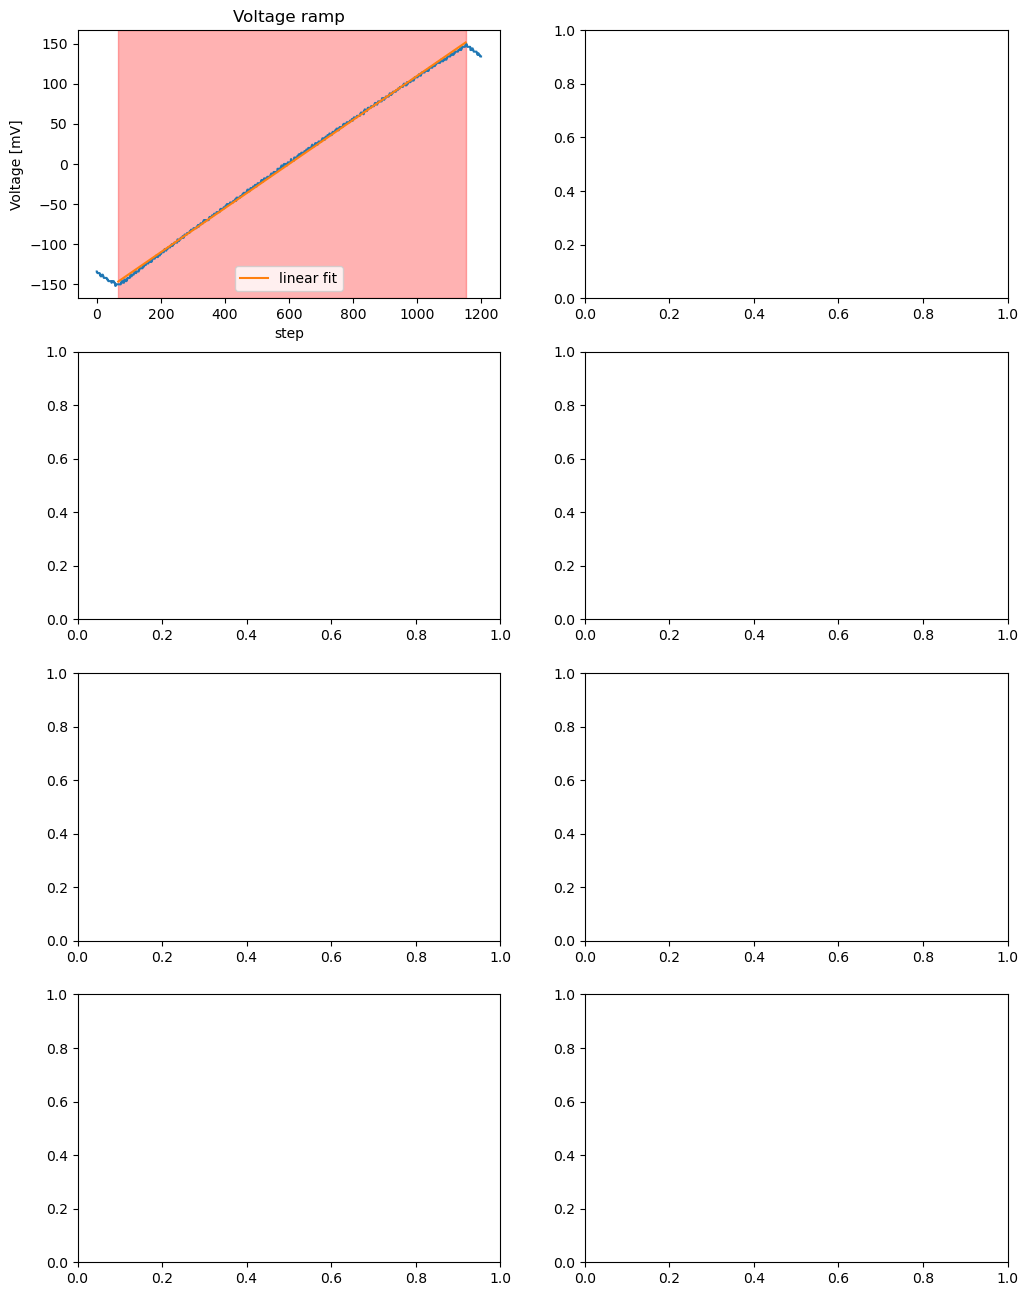

In [119]:


# find the regions where the signal is linear



# save same signal both as DC and AC, the first column is the function generator, the second the photodiode
DC_signal = np.loadtxt("/media/jacklook/JL_USB/NewFile13.csv", skiprows=2,delimiter=",",dtype=str)
AC_signal = np.loadtxt("/media/jacklook/JL_USB/NewFile12.csv", skiprows=2,delimiter=",",dtype=str)


# find extremes of the voltage ramp and cuts the data there
V_fgen_DC = DC_signal[:,1].astype(float)*1000 # in mV
start,end = find_extremes_ramp(V_fgen_DC)
t_all = np.arange(0,len(V_fgen_DC))
t = t_all[start:end]

# extract the data between the extremes
V_DC = (DC_signal[:,2].astype(float))[start:end]
V_AC = (AC_signal[:,2].astype(float))[start:end]

# find the relation between step and ramp voltage by linear fit
Vf_vs_t__linfit = np.polyfit(t,V_fgen_DC[start:end],1)
Vf_vs_t__a = Vf_vs_t__linfit[0]
Vf_vs_t__b = Vf_vs_t__linfit[1]
Vf = Vf_vs_t__a*t + Vf_vs_t__b

fig,ax = plt.subplots(4,2,figsize=(12,16))
ax[0,0].plot(t_all,V_fgen_DC)
ax[0,0].set_title('Voltage ramp')
ax[0,0].set_xlabel('step')
ax[0,0].set_ylabel('Voltage [mV]')
ax[0,0].plot(t,t*Vf_vs_t__a+Vf_vs_t__b,label='linear fit')
ax[0,0].axvspan(start,end,color='r',alpha=0.3)
ax[0,0].legend()

# correct AC signal for DC offset
Vpd = V_AC + np.mean(V_DC)-np.mean(V_AC)

# find where the signal is linear and correct it
starts,ends = find_where_linear(Vpd)
lin_indexes = np.arange(int(starts[0]),int(ends[0]))
for i in range(1,4):
    lin_indexes = np.concatenate((lin_indexes,np.arange(int(starts[i]),int(ends[i]))))
lin_indexes = lin_indexes.astype(int)
Vf_lin = Vf[lin_indexes]
Vpd_lin = Vpd[lin_indexes]
Vpd_vs_Vf_linfit = np.polyfit(Vf_lin,Vpd_lin,1)
Vpd_vs_Vf_a = Vpd_vs_Vf_linfit[0]
Vpd_vs_Vf_b = Vpd_vs_Vf_linfit[1]
Vpd_lin = Vf*Vpd_vs_Vf_a+Vpd_vs_Vf_b


ax[0,1].plot(Vf,V_DC,label='DC')
ax[0,1].plot(Vf,Vpd,label='AC corrected')
ax[0,1].set_xlabel('Voltage FG [mV]')
ax[0,1].set_ylabel('Voltage PD [mV]')
for i in range(4):
    ax[0,1].axvspan(Vf[int(starts[i])],Vf[int(ends[i])],color='r',alpha=0.3)
ax[0,1].plot(Vf,Vf*Vpd_vs_Vf_a+Vpd_vs_Vf_b,label='linear fit')
ax[0,1].legend()

# get the absorption signal
Spd = -np.log(Vpd/Vpd_lin)

# find the gaussians
gauss_centers = np.array([(ends[0]+starts[1])/2, (ends[1]+starts[2])/2, ends[2]+(starts[3]-ends[2])/4, ends[2]+(starts[3]-ends[2])/4*3])
for i in range(4):
    gauss_centers[i] = Vf[int(gauss_centers[i])]
gauss_starts = np.array([ends[0],ends[1],ends[2],ends[2]+(starts[3]-ends[2])/2])
gauss_ends = np.array([starts[1],starts[2],starts[3]-(starts[3]-ends[2])/2,starts[3]])
gauss_widths = np.zeros(4)
gauss_A = np.zeros(4)
for i in range(4):
    start = int(gauss_starts[i])
    end = int(gauss_ends[i])
    t = np.arange(start,end)
    popt, pcov = curve_fit(Gauss, Vf[t], Spd[t], p0=[1, 1, gauss_centers[i]])
    gauss_centers[i] = popt[2]
    gauss_widths[i] = popt[1]
    gauss_A[i] = popt[0]

# fit Vf vs f
Vf_vs_f_linfit = np.polyfit(fl_array, gauss_centers, 1)
Vf_vs_f__a = Vf_vs_f_linfit[0]
Vf_vs_f__b = Vf_vs_f_linfit[1]
fs = (Vf-Vf_vs_f__b)/Vf_vs_f__a

ax[1,1].plot(fl_array, gauss_centers, 'o', label='data')
fl_s = np.arange(fl_array[-1]-1000,fl_array[0]+1000)
ax[1,1].plot(fl_s, np.polyval(Vf_vs_f_linfit, fl_s), label='linear fit')
ax[1,1].set_xlabel('laser frequency (MHz)')
ax[1,1].set_ylabel('central position of the gaussian (Vf)')

gauss_centers = (gauss_centers-Vf_vs_f__b)/Vf_vs_f__a
gauss_widths = abs(gauss_widths/Vf_vs_f__a)

# sum all gaussians
Spd_fit = np.zeros(len(Vf))
Spd_fit += Gauss(fs,gauss_A[0],gauss_widths[0],gauss_centers[0])
Spd_fit += Gauss(fs,gauss_A[1],gauss_widths[1],gauss_centers[1])
Spd_fit += Gauss(fs,gauss_A[2],gauss_widths[2],gauss_centers[2])
Spd_fit += Gauss(fs,gauss_A[3],gauss_widths[3],gauss_centers[3])

ax[1,0].plot(fs,Spd)
ax[1,0].plot(fs,Spd_fit)
ax[1,0].set_xlabel('laser frequency (MHz)')
ax[1,0].set_ylabel('absorption signal')

# get the voltage for the laser frequency
def get_V(FL):
    return FL*Vf_vs_f__a+Vf_vs_f__b

print(gauss_centers)
print(gauss_widths)
Vf_a_1 = Vf_vs_f__a
Vf_b_1 = Vf_vs_f__b
print(Vf_vs_f__a,Vf_vs_f__b)




62 1147
[417.654574, 13.6656716, 0.191280107, 270.869575, 11.352514, 0.529115628, 99.2989019, 51.2293709, 0.639558107, 516.399684, 9.38985782, 0.184089569, 658.149167, 11.8673991, 0.173500164, 897.277681, 5.53773378, 0.0108919266, 1066.78415, 298.93927]
[4.17654610e+02 1.36655677e+01 1.91275984e-01 2.70869548e+02
 1.13520524e+01 5.29101065e-01 9.92980414e+01 5.12320622e+01
 6.39502264e-01 5.16399685e+02 9.38985457e+00 1.84087150e-01
 6.58149174e+02 1.18673985e+01 1.73499681e-01 8.97277680e+02
 5.53772915e+00 1.08919721e-02 1.06678786e+03 2.98942415e+02]


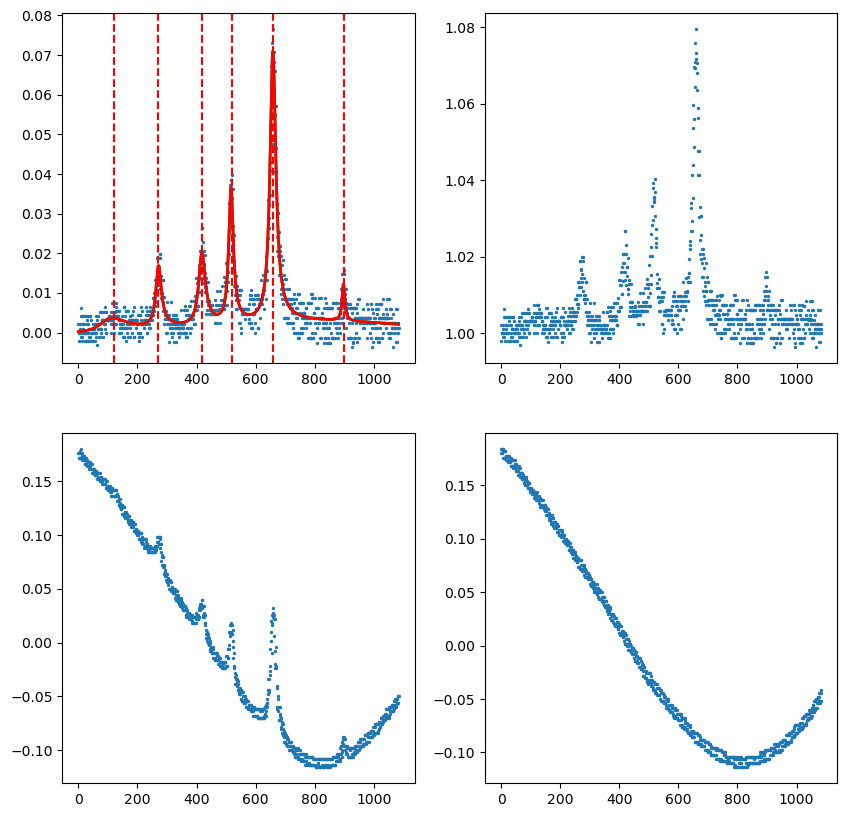

In [26]:
# plot files 18,19,29,21 froom JL_USB
V_1 = np.loadtxt("/media/jacklook/JL_USB/NewFile18.csv",skiprows=2,delimiter=",",dtype=str)
V_2 = np.loadtxt("/media/jacklook/JL_USB/NewFile19.csv",skiprows=2,delimiter=",",dtype=str)
V_3 = np.loadtxt("/media/jacklook/JL_USB/NewFile20.csv",skiprows=2,delimiter=",",dtype=str)
V_4 = np.loadtxt("/media/jacklook/JL_USB/NewFile21.csv",skiprows=2,delimiter=",",dtype=str)

V_0 = V_1[:,2].astype(float)
st,end = find_extremes_ramp(V_0)

print(st,end)
V_1 = V_1[st:end,1].astype(float)
V_2 = V_2[st:end,1].astype(float)
V_3 = V_3[st:end,1].astype(float)
V_4 = V_4[st:end,1].astype(float)

V_DB = V_1 -np.mean(V_1)+np.mean(V_2)
V_DF = V_4 -np.mean(V_4)+np.mean(V_3)

sg = np.log(V_DB/V_DF)

# plot in 4 different graphs
fig, axs = plt.subplots(2,2)
fig.set_size_inches(10, 10)
axs[1,0].scatter(np.arange(0,len(V_1)),V_1,s=2)
axs[1,1].scatter(np.arange(0,len(V_2)),V_4,s=2)
axs[0,0].scatter(np.arange(0,len(sg)),sg,s=2)
axs[0,1].scatter(np.arange(0,len(sg)),V_DB/V_DF,s=2)

in_centers = np.array([120,270,420,520,660,900])
# plot vertical lines
for i in range(len(in_centers)):
    axs[0,0].axvline(x=in_centers[i],color='r',linestyle='--')

# plot the SAS_fit function
x = np.arange(0,len(sg))
p0=[4.17654574e+02, 1.36656716e+01, 1.91280107e-01, 
    2.70869575e+02, 1.13525140e+01, 5.29115628e-01, 
    9.92989019e+01, 5.12293709e+01, 6.39558107e-01, 
    5.16399684e+02, 9.38985782e+00, 1.84089569e-01, 
    6.58149167e+02, 1.18673991e+01, 1.73500164e-01, 
    8.97277681e+02, 5.53773378e+00, 1.08919266e-02, 
    1.06678415e+03, 2.98939270e+02]
axs[0,0].plot(x,SAS_fit(x,*p0),c='g',lw=2)
#axs[0,0].plot(x,Gauss(x,0.005,500,600))
popt, pcov = curve_fit(SAS_fit, x, sg, p0)
print(p0)
print(popt)
axs[0,0].plot(x,SAS_fit(x,*popt),lw=2,c='r')
plt.show()


[   34.14796331 -2625.46093108 -5644.23246438 -6793.45456785]
[284.81663086 277.06596559 285.97350971 313.1734811 ]
-0.024219524841069685 -82.57097671180641


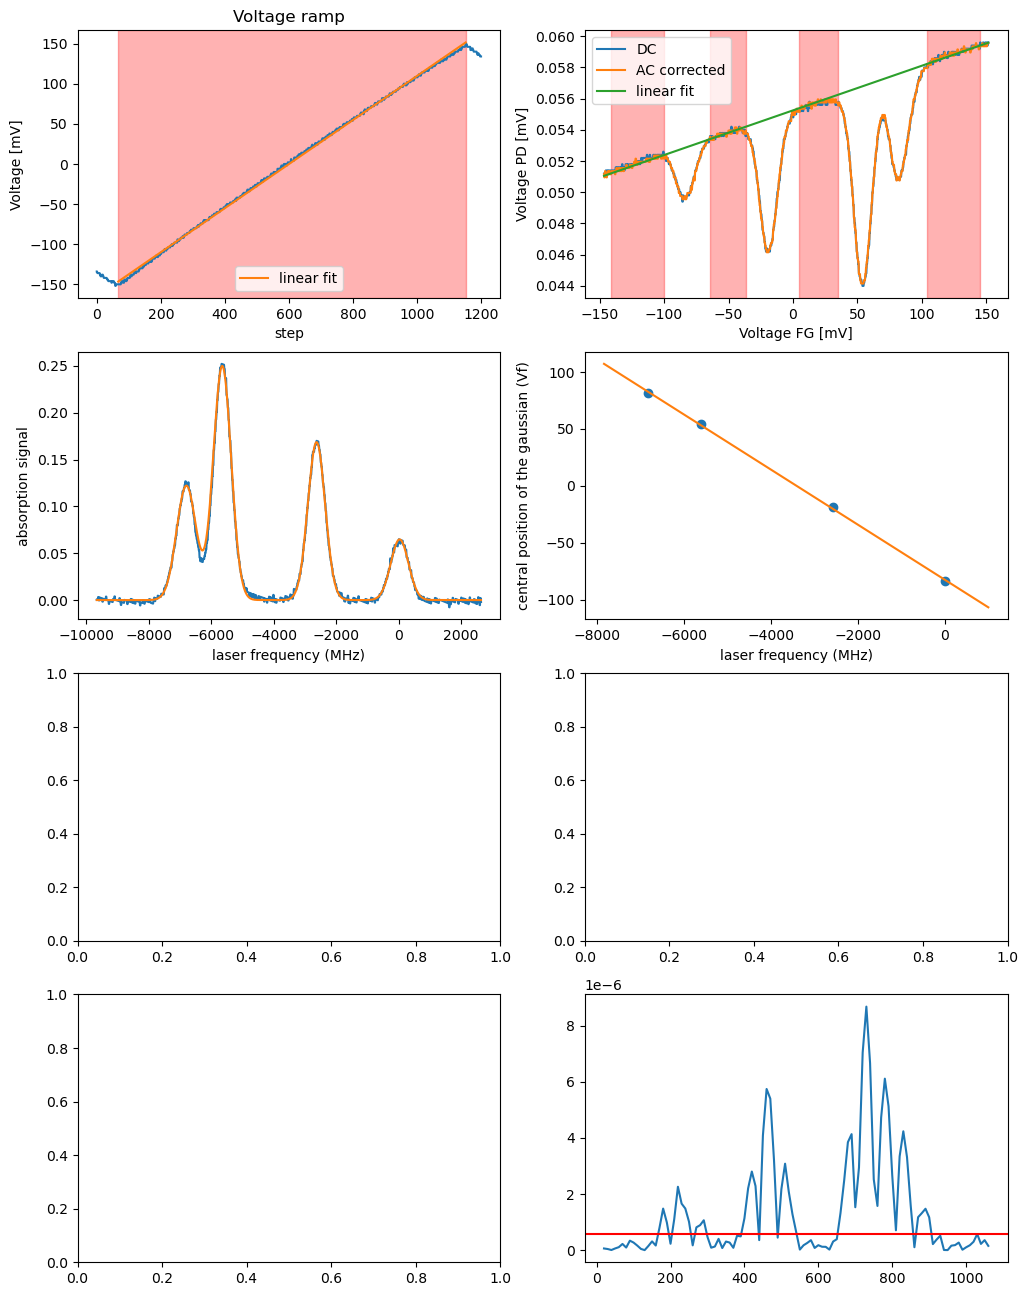

In [ ]:

# save same signal both as DC and AC, the first column is the function generator, the second the photodiode
DC_signal = np.loadtxt("/media/jacklook/JL_USB/NewFile13.csv", skiprows=2,delimiter=",",dtype=str)
AC_signal = np.loadtxt("/media/jacklook/JL_USB/NewFile12.csv", skiprows=2,delimiter=",",dtype=str)


# find extremes of the voltage ramp and cuts the data there
V_fgen_DC = DC_signal[:,1].astype(float)*1000 # in mV
start,end = find_extremes_ramp(V_fgen_DC)
t_all = np.arange(0,len(V_fgen_DC))
t = t_all[start:end]

# extract the data between the extremes
V_DC = (DC_signal[:,2].astype(float))[start:end]
V_AC = (AC_signal[:,2].astype(float))[start:end]

# find the relation between step and ramp voltage by linear fit
Vf_vs_t__linfit = np.polyfit(t,V_fgen_DC[start:end],1)
Vf_vs_t__a = Vf_vs_t__linfit[0]
Vf_vs_t__b = Vf_vs_t__linfit[1]
Vf = Vf_vs_t__a*t + Vf_vs_t__b

fig,ax = plt.subplots(4,2,figsize=(12,16))
ax[0,0].plot(t_all,V_fgen_DC)
ax[0,0].set_title('Voltage ramp')
ax[0,0].set_xlabel('step')
ax[0,0].set_ylabel('Voltage [mV]')
ax[0,0].plot(t,t*Vf_vs_t__a+Vf_vs_t__b,label='linear fit')
ax[0,0].axvspan(start,end,color='r',alpha=0.3)
ax[0,0].legend()

# correct AC signal for DC offset
Vpd = V_AC + np.mean(V_DC)-np.mean(V_AC)

# find where the signal is linear and correct it
starts,ends = find_where_linear(Vpd)
lin_indexes = np.arange(int(starts[0]),int(ends[0]))
for i in range(1,4):
    lin_indexes = np.concatenate((lin_indexes,np.arange(int(starts[i]),int(ends[i]))))
lin_indexes = lin_indexes.astype(int)
Vf_lin = Vf[lin_indexes]
Vpd_lin = Vpd[lin_indexes]
Vpd_vs_Vf_linfit = np.polyfit(Vf_lin,Vpd_lin,1)
Vpd_vs_Vf_a = Vpd_vs_Vf_linfit[0]
Vpd_vs_Vf_b = Vpd_vs_Vf_linfit[1]
Vpd_lin = Vf*Vpd_vs_Vf_a+Vpd_vs_Vf_b


ax[0,1].plot(Vf,V_DC,label='DC')
ax[0,1].plot(Vf,Vpd,label='AC corrected')
ax[0,1].set_xlabel('Voltage FG [mV]')
ax[0,1].set_ylabel('Voltage PD [mV]')
for i in range(4):
    ax[0,1].axvspan(Vf[int(starts[i])],Vf[int(ends[i])],color='r',alpha=0.3)
ax[0,1].plot(Vf,Vf*Vpd_vs_Vf_a+Vpd_vs_Vf_b,label='linear fit')
ax[0,1].legend()

# get the absorption signal
Spd = -np.log(Vpd/Vpd_lin)

# find the gaussians
gauss_centers = np.array([(ends[0]+starts[1])/2, (ends[1]+starts[2])/2, ends[2]+(starts[3]-ends[2])/4, ends[2]+(starts[3]-ends[2])/4*3])
for i in range(4):
    gauss_centers[i] = Vf[int(gauss_centers[i])]
gauss_starts = np.array([ends[0],ends[1],ends[2],ends[2]+(starts[3]-ends[2])/2])
gauss_ends = np.array([starts[1],starts[2],starts[3]-(starts[3]-ends[2])/2,starts[3]])
gauss_widths = np.zeros(4)
gauss_A = np.zeros(4)
for i in range(4):
    start = int(gauss_starts[i])
    end = int(gauss_ends[i])
    t = np.arange(start,end)
    popt, pcov = curve_fit(Gauss, Vf[t], Spd[t], p0=[1, 1, gauss_centers[i]])
    gauss_centers[i] = popt[2]
    gauss_widths[i] = popt[1]
    gauss_A[i] = popt[0]

# fit Vf vs f
Vf_vs_f_linfit = np.polyfit(fl_array, gauss_centers, 1)
Vf_vs_f__a = Vf_vs_f_linfit[0]
Vf_vs_f__b = Vf_vs_f_linfit[1]
fs = (Vf-Vf_vs_f__b)/Vf_vs_f__a

ax[1,1].plot(fl_array, gauss_centers, 'o', label='data')
fl_s = np.arange(fl_array[-1]-1000,fl_array[0]+1000)
ax[1,1].plot(fl_s, np.polyval(Vf_vs_f_linfit, fl_s), label='linear fit')
ax[1,1].set_xlabel('laser frequency (MHz)')
ax[1,1].set_ylabel('central position of the gaussian (Vf)')

gauss_centers = (gauss_centers-Vf_vs_f__b)/Vf_vs_f__a
gauss_widths = abs(gauss_widths/Vf_vs_f__a)

# sum all gaussians
Spd_fit = np.zeros(len(Vf))
Spd_fit += Gauss(fs,gauss_A[0],gauss_widths[0],gauss_centers[0])
Spd_fit += Gauss(fs,gauss_A[1],gauss_widths[1],gauss_centers[1])
Spd_fit += Gauss(fs,gauss_A[2],gauss_widths[2],gauss_centers[2])
Spd_fit += Gauss(fs,gauss_A[3],gauss_widths[3],gauss_centers[3])

ax[1,0].plot(fs,Spd)
ax[1,0].plot(fs,Spd_fit)
ax[1,0].set_xlabel('laser frequency (MHz)')
ax[1,0].set_ylabel('absorption signal')

# get the voltage for the laser frequency
def get_V(FL):
    return FL*Vf_vs_f__a+Vf_vs_f__b

print(gauss_centers)
print(gauss_widths)
Vf_a_1 = Vf_vs_f__a
Vf_b_1 = Vf_vs_f__b
print(Vf_vs_f__a,Vf_vs_f__b)




[   33.57445023 -2626.67889633 -5636.77047913 -6799.12507477]
[258.97800325 239.48680717 240.84309937 254.90809932]
-2.1712379212464583


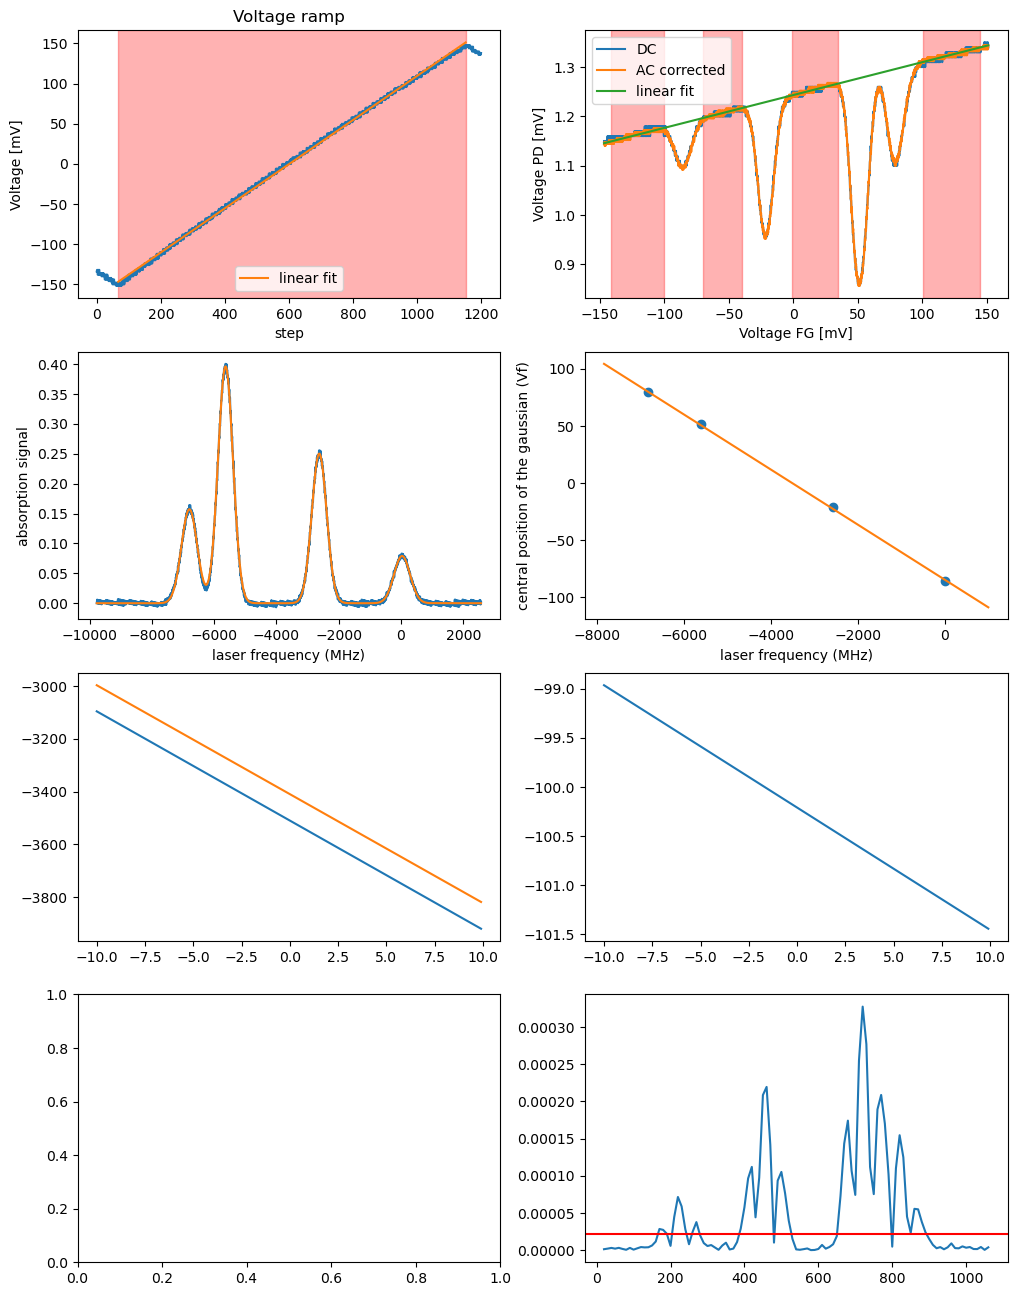

In [ ]:
DC_signal = np.loadtxt("/media/jacklook/JL_USB/NewFile9.csv", skiprows=2,delimiter=",",dtype=str)
AC_signal = np.loadtxt("/media/jacklook/JL_USB/NewFile8.csv", skiprows=2,delimiter=",",dtype=str)


# find extremes of the voltage ramp
V_fgen_DC = DC_signal[:,1].astype(float)*1000 # in mV
start,end = find_extremes_ramp(V_fgen_DC)
t_all = np.arange(0,len(V_fgen_DC))
t = t_all[start:end]

# extract the data between the extremes
V_DC = (DC_signal[:,2].astype(float))[start:end]
V_AC = (AC_signal[:,2].astype(float))[start:end]

# find the relation between step and ramp voltage
Vf_vs_t__linfit = np.polyfit(t,V_fgen_DC[start:end],1)
Vf_vs_t__a = Vf_vs_t__linfit[0]
Vf_vs_t__b = Vf_vs_t__linfit[1]
Vf = Vf_vs_t__a*t + Vf_vs_t__b

fig,ax = plt.subplots(4,2,figsize=(12,16))
ax[0,0].plot(t_all,V_fgen_DC)
ax[0,0].set_title('Voltage ramp')
ax[0,0].set_xlabel('step')
ax[0,0].set_ylabel('Voltage [mV]')
ax[0,0].plot(t,t*Vf_vs_t__a+Vf_vs_t__b,label='linear fit')
ax[0,0].axvspan(start,end,color='r',alpha=0.3)
ax[0,0].legend()

# correct AC signal for DC offset
Vpd = V_AC + np.mean(V_DC)-np.mean(V_AC)

# find where the signal is linear and correct it
starts,ends = find_where_linear(Vpd)
lin_indexes = np.arange(int(starts[0]),int(ends[0]))
for i in range(1,4):
    lin_indexes = np.concatenate((lin_indexes,np.arange(int(starts[i]),int(ends[i]))))
lin_indexes = lin_indexes.astype(int)
Vf_lin = Vf[lin_indexes]
Vpd_lin = Vpd[lin_indexes]
Vpd_vs_Vf_linfit = np.polyfit(Vf_lin,Vpd_lin,1)
Vpd_vs_Vf_a = Vpd_vs_Vf_linfit[0]
Vpd_vs_Vf_b = Vpd_vs_Vf_linfit[1]
Vpd_lin = Vf*Vpd_vs_Vf_a+Vpd_vs_Vf_b


ax[0,1].plot(Vf,V_DC,label='DC')
ax[0,1].plot(Vf,Vpd,label='AC corrected')
ax[0,1].set_xlabel('Voltage FG [mV]')
ax[0,1].set_ylabel('Voltage PD [mV]')
for i in range(4):
    ax[0,1].axvspan(Vf[int(starts[i])],Vf[int(ends[i])],color='r',alpha=0.3)
ax[0,1].plot(Vf,Vf*Vpd_vs_Vf_a+Vpd_vs_Vf_b,label='linear fit')
ax[0,1].legend()

# get the absorption signal
Spd = -np.log(Vpd/Vpd_lin)

# find the gaussians
gauss_centers = np.array([(ends[0]+starts[1])/2, (ends[1]+starts[2])/2, ends[2]+(starts[3]-ends[2])/4, ends[2]+(starts[3]-ends[2])/4*3])
for i in range(4):
    gauss_centers[i] = Vf[int(gauss_centers[i])]
gauss_starts = np.array([ends[0],ends[1],ends[2],ends[2]+(starts[3]-ends[2])/2])
gauss_ends = np.array([starts[1],starts[2],starts[3]-(starts[3]-ends[2])/2,starts[3]])
gauss_widths = np.zeros(4)
gauss_A = np.zeros(4)
for i in range(4):
    start = int(gauss_starts[i])
    end = int(gauss_ends[i])
    t = np.arange(start,end)
    popt, pcov = curve_fit(Gauss, Vf[t], Spd[t], p0=[1, 1, gauss_centers[i]])
    gauss_centers[i] = popt[2]
    gauss_widths[i] = popt[1]
    gauss_A[i] = popt[0]

# fit Vf vs f
Vf_vs_f_linfit = np.polyfit(fl_array, gauss_centers, 1)
Vf_vs_f__a = Vf_vs_f_linfit[0]
Vf_vs_f__b = Vf_vs_f_linfit[1]
fs = (Vf-Vf_vs_f__b)/Vf_vs_f__a

ax[1,1].plot(fl_array, gauss_centers, 'o', label='data')
fl_s = np.arange(fl_array[-1]-1000,fl_array[0]+1000)
ax[1,1].plot(fl_s, np.polyval(Vf_vs_f_linfit, fl_s), label='linear fit')
ax[1,1].set_xlabel('laser frequency (MHz)')
ax[1,1].set_ylabel('central position of the gaussian (Vf)')

gauss_centers = (gauss_centers-Vf_vs_f__b)/Vf_vs_f__a
gauss_widths = abs(gauss_widths/Vf_vs_f__a)

# sum all gaussians
Spd_fit = np.zeros(len(Vf))
Spd_fit += Gauss(fs,gauss_A[0],gauss_widths[0],gauss_centers[0])
Spd_fit += Gauss(fs,gauss_A[1],gauss_widths[1],gauss_centers[1])
Spd_fit += Gauss(fs,gauss_A[2],gauss_widths[2],gauss_centers[2])
Spd_fit += Gauss(fs,gauss_A[3],gauss_widths[3],gauss_centers[3])

ax[1,0].plot(fs,Spd)
ax[1,0].plot(fs,Spd_fit)
ax[1,0].set_xlabel('laser frequency (MHz)')
ax[1,0].set_ylabel('absorption signal')

# get the voltage for the laser frequency
def get_V(FL):
    return FL*Vf_vs_f__a+Vf_vs_f__b

print(gauss_centers)
print(gauss_widths)
Vf = np.arange(-10,10,0.1)
ax[2,0].plot(Vf,(Vf-Vf_vs_f__b)/Vf_vs_f__a)
ax[2,0].plot(Vf,(Vf-Vf_b_1)/Vf_a_1)
ax[2,1].plot(Vf,(Vf-Vf_vs_f__b)/Vf_vs_f__a-(Vf-Vf_b_1)/Vf_a_1)
print(Vf_vs_f__b-Vf_b_1)



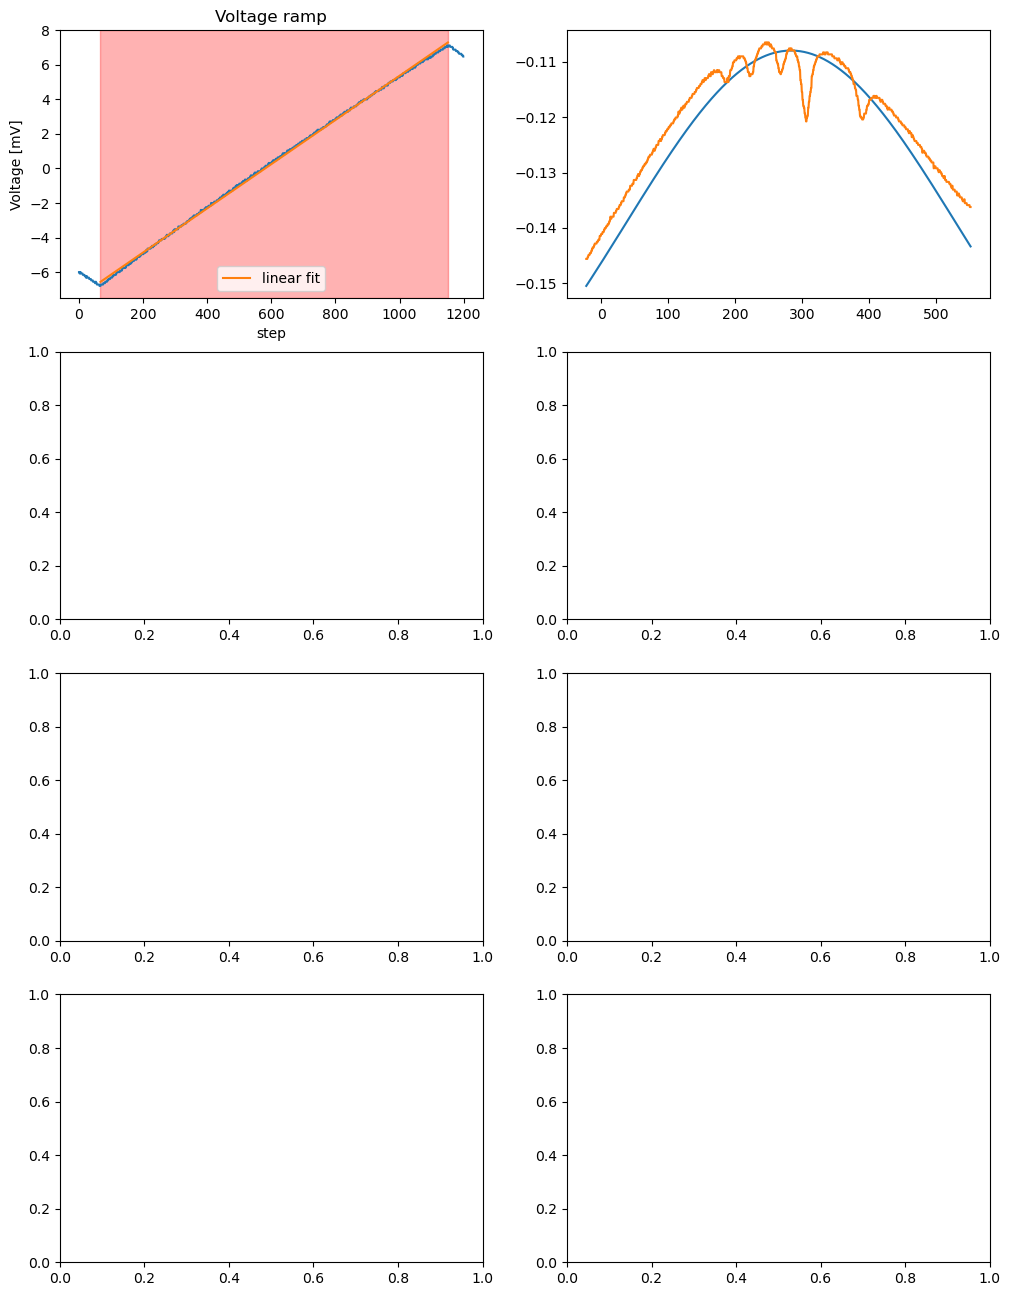

In [ ]:
DC_signal = np.loadtxt("/media/jacklook/JL_USB/NewFile10.csv", skiprows=2,delimiter=",",dtype=str)
AC_signal = np.loadtxt("/media/jacklook/JL_USB/NewFile11.csv", skiprows=2,delimiter=",",dtype=str)

# find extremes of the voltage ramp
V_fgen_DC = DC_signal[:,1].astype(float)*1000 # in mV
start,end = find_extremes_ramp(V_fgen_DC)
t_all = np.arange(0,len(V_fgen_DC))
t = t_all[start:end]

# extract the data between the extremes
V_DC = (DC_signal[:,2].astype(float))[start:end]
V_AC = (AC_signal[:,2].astype(float))[start:end]
Vpd = V_AC + np.mean(V_DC)-np.mean(V_AC)

# find the relation between step and ramp voltage
Vf_vs_t__linfit = np.polyfit(t,V_fgen_DC[start:end],1)
Vf_vs_t__a = Vf_vs_t__linfit[0]
Vf_vs_t__b = Vf_vs_t__linfit[1]
Vf = Vf_vs_t__a*t + Vf_vs_t__b-91.5

fig,ax = plt.subplots(4,2,figsize=(12,16))
ax[0,0].plot(t_all,V_fgen_DC)
ax[0,0].set_title('Voltage ramp')
ax[0,0].set_xlabel('step')
ax[0,0].set_ylabel('Voltage [mV]')
ax[0,0].plot(t,t*Vf_vs_t__a+Vf_vs_t__b,label='linear fit')
ax[0,0].axvspan(start,end,color='r',alpha=0.3)
ax[0,0].legend()

HF_f = (Vf-Vf_vs_f__b)/Vf_vs_f__a

ax[0,1].plot(HF_f,Gauss(HF_f,gauss_A[0]*1.,gauss_widths[0]*0.95,gauss_centers[0]+250)-0.187,label='DC')
ax[0,1].plot(HF_f,-np.log(Vpd),label='DC')



NameError: name 'HF_Vpd' is not defined

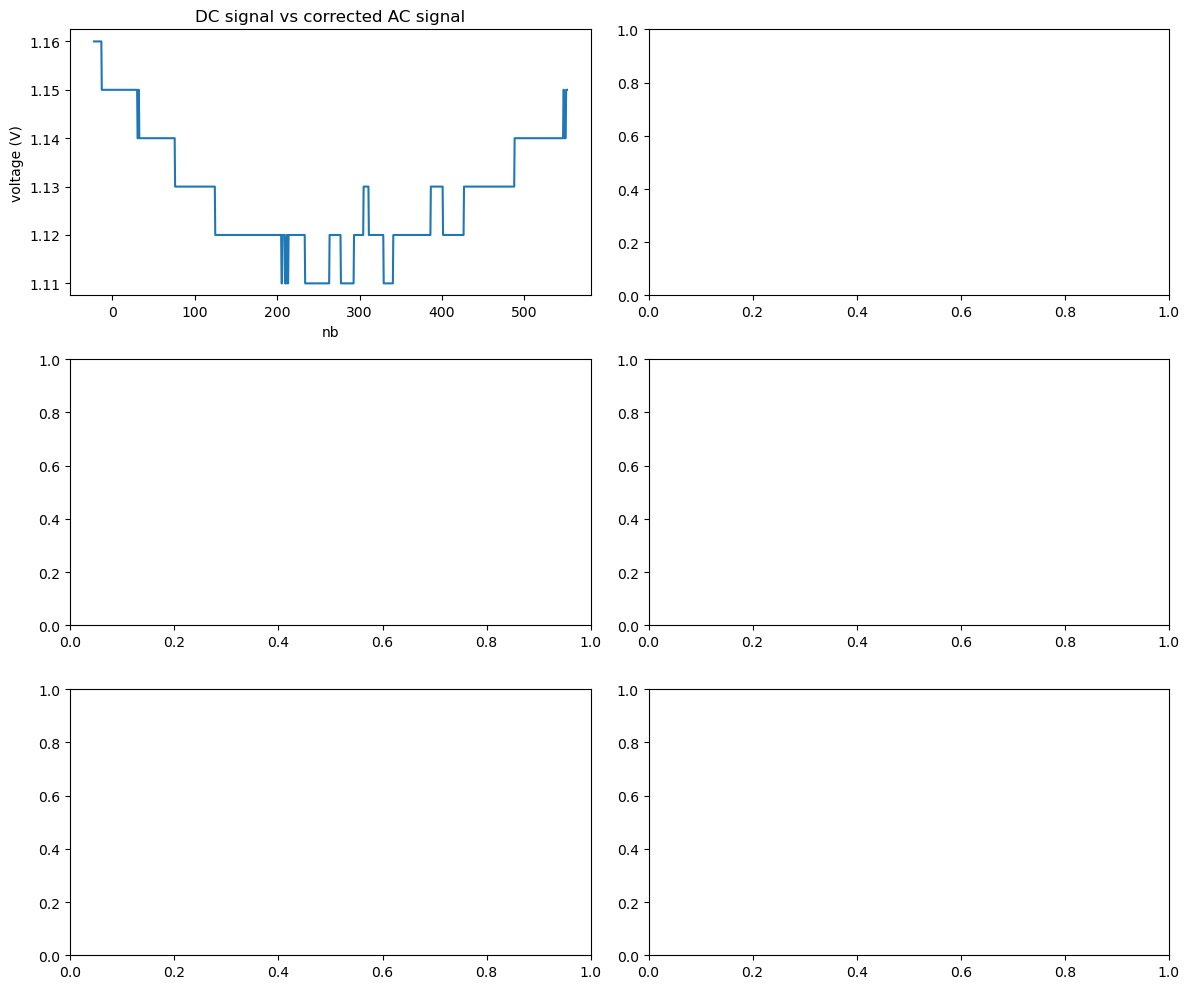

In [ ]:
# plot the data
fig, ax = plt.subplots(3, 2, figsize=(12, 10),tight_layout=True)
ax[0,0].plot(HF_f, V_DC, label='DC signal')
ax[0,0].set_title('DC signal vs corrected AC signal')
ax[0,0].set_xlabel('nb')
ax[0,0].set_ylabel('voltage (V)')
ax[0,0].plot(HF_f,HF_Vpd, label='AC signal corrected')
ax[0,0].legend()
ax[0,1].plot(t_AC, HF_Vf_vs_t__a*t_AC+HF_Vf_vs_t__b-91.5)

#HF_Vpd = HF_Vpd/(Vpd_vs_Vf__a*((t_AC*HF_Vf_vs_t__a+HF_Vf_vs_t__b-91.5)+Vpd_vs_Vf__b))

print(x0[0])
V_abs = np.zeros(len(HF_Vpd))
for i in range(len(HF_Vpd)):
    try:
        V_abs[i] = -np.log(HF_Vpd[i])
        print(HF_Vpd[i],V_abs[i])
    except:
        print(HF_Vpd[i])
ax[0,1].plot(HF_f, V_abs, label='AC signal corrected')
ax[1,1].plot((t_AC*HF_Vf_vs_t__a+HF_Vf_vs_t__b-91.5)*a_Vf+b_Vf,Vpd_vs_Vf__a*(t_AC*HF_Vf_vs_t__a+HF_Vf_vs_t__b-91.5)+Vpd_vs_Vf__b)
ax[1,0].plot(HF_f,-np.log(HF_Vpd))


[237.73606802 505.7734614  809.14347737 925.72642261]


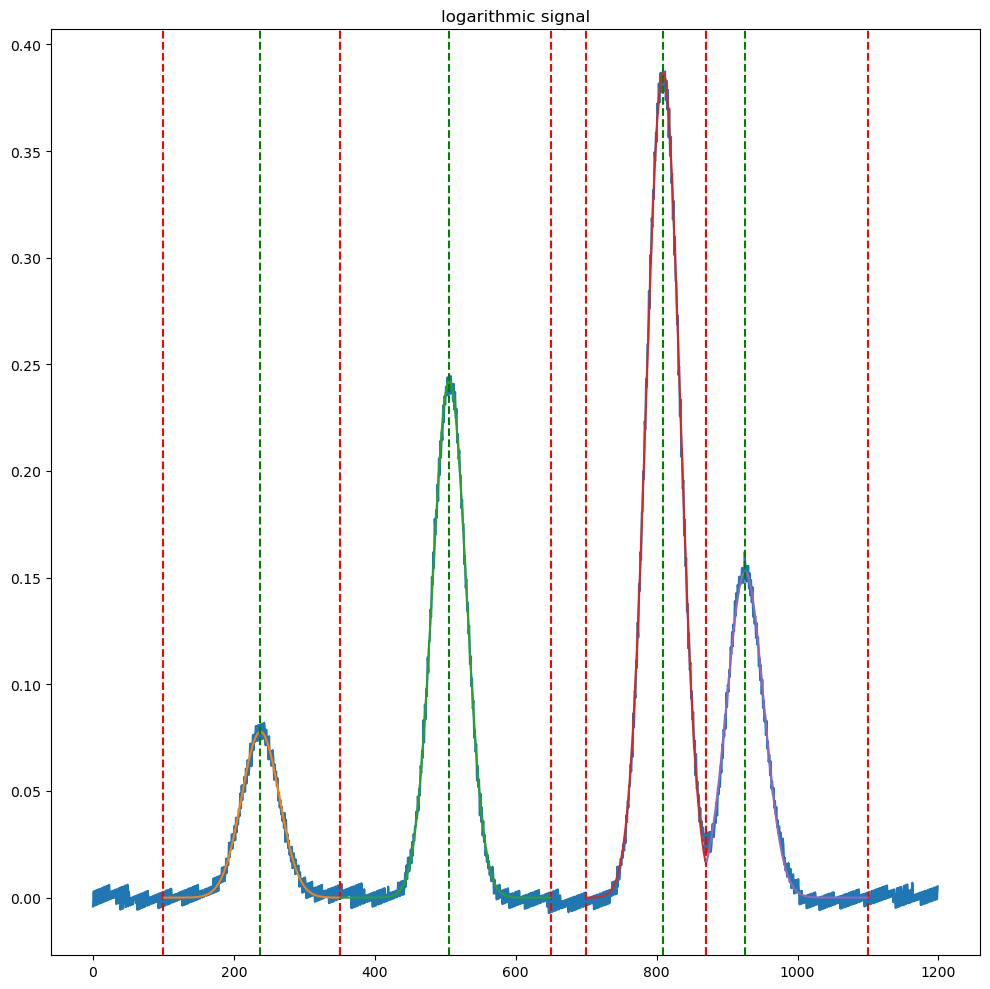

In [ ]:
# plot V,t divided by linear fit and take the negative of their log
V_lin = V/np.polyval(lin_fit, t)
t_lin = t
V_abs = -np.log(V_lin)
t_log = t_lin
fig,axt = plt.subplots(1, 1, figsize=(10, 10),tight_layout=True)
axt.plot(t_log, V_abs)
axt.set_title('logarithmic signal') 
t_gauss_start = [100,350,700,870]
t_gauss_end = [350,650,870,1100]
# plot vertical lines in ax2 at t_starts and t_ends
for t_start, t_end in zip(t_gauss_start, t_gauss_end):
    axt.axvline(t_start, color='r', linestyle='--')
    axt.axvline(t_end, color='r', linestyle='--')

# select the data between t_start and t_end, do a gaussian fit and plot the fit and save the center positions in an array
x0 = np.array([])
for t_start, t_end in zip(t_gauss_start, t_gauss_end):
    V_gauss = V_abs[(t_log > t_start) & (t_log < t_end)]
    t_gauss = t_log[(t_log > t_start) & (t_log < t_end)]
    popt, pcov = curve_fit(Gauss, t_gauss, V_gauss, p0=[1, 1, (t_start+t_end)/2])
    x0 = np.append(x0, popt[2])
    axt.plot(t_gauss, Gauss(t_gauss, *popt), label='Gaussian fit')

# plot the center positions of the gaussians as vertical lines
for x in x0:
    axt.axvline(x, color='g', linestyle='--')

# print center positions
print(x0)

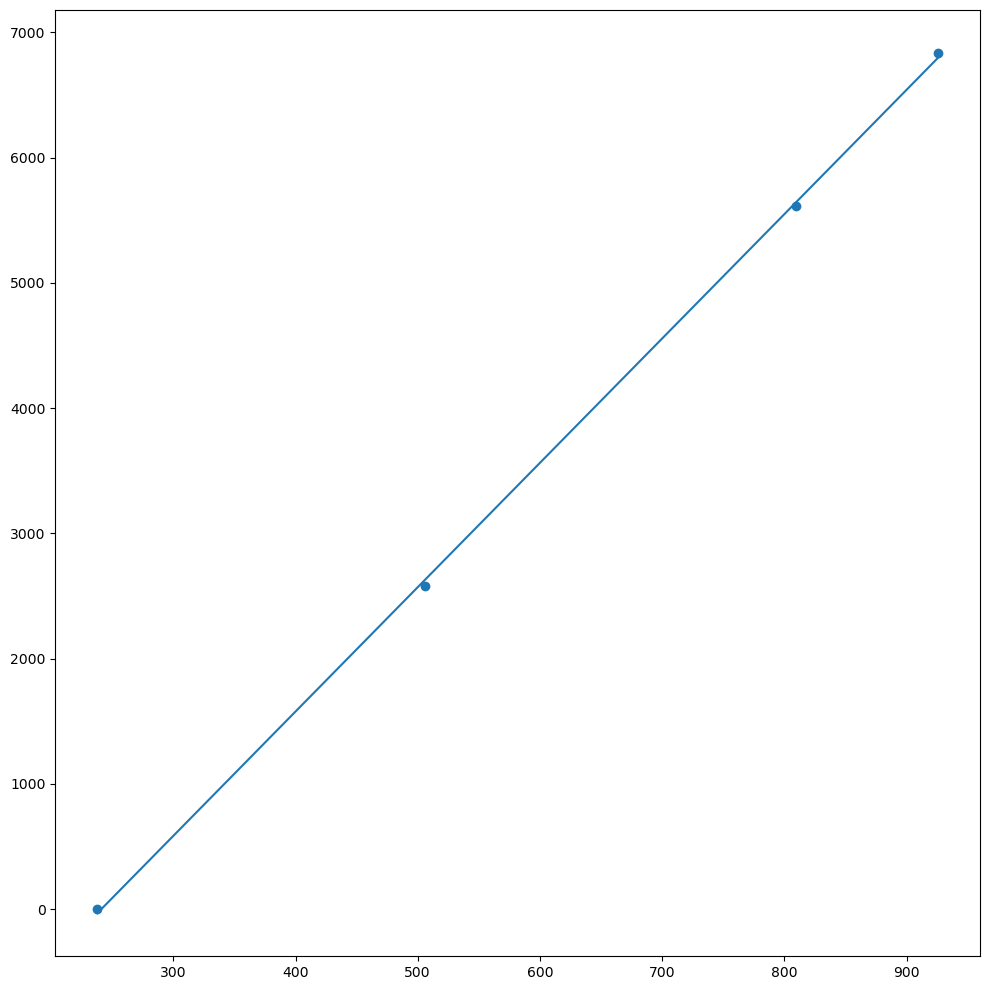

In [ ]:
D_real = np.array([0,2579,5615,6835])
# make a linear fit to the center positions and the real distances
lin_fit = np.polyfit(x0, D_real, 1)
fig,axt = plt.subplots(1, 1, figsize=(10, 10),tight_layout=True)
# plot the linear fit
axt.plot(x0, np.polyval(lin_fit, x0), label='linear fit')
# plot the original data
axt.scatter(x0, D_real, label='real distances')


[ -33.5511579  2627.31848708 5638.94330738 6796.28936345]
6829.840521350624


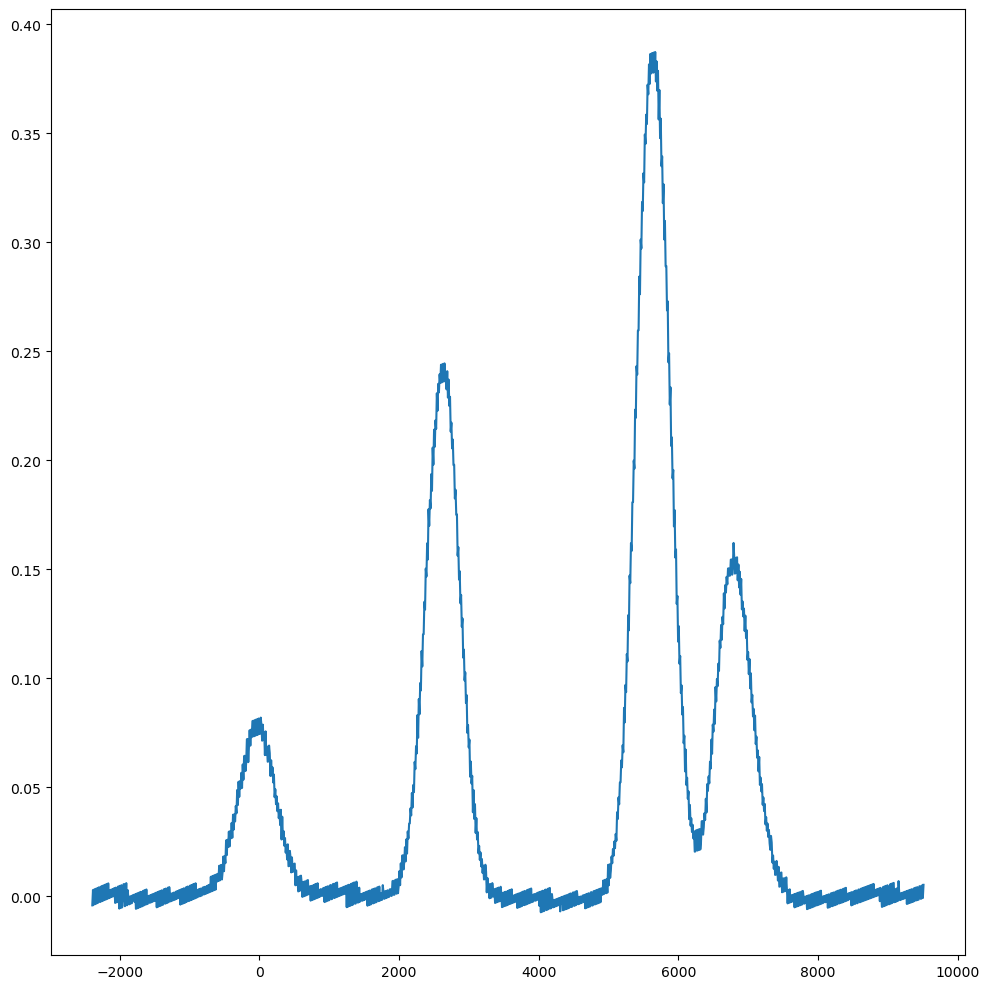

In [ ]:
# rescale t_log with the linear fit
f_x = np.polyval(lin_fit, t_log)
fig,axt = plt.subplots(1, 1, figsize=(10, 10),tight_layout=True)
axt.plot(f_x,V_abs)
f0 = np.polyval(lin_fit, x0)
print(f0)
print(f0[3]-f0[0])


mean of signal is -0.07889
std of signal is 0.0943035236174485
max of signal is 0.068
min of signal is -0.388
peak to peak of signal is 0.456
V_linear is [0.9063404  0.92634107 0.92634107 0.9063404  0.9063404  0.92634107
 0.9063404  0.92634107 0.9063404  0.92634107 0.9063404  0.92634107
 0.9063404  0.92634107 0.92634107 0.8964881  0.91629073 0.8964881
 0.91629073 0.8964881  0.91629073 0.8964881  0.8964881  0.91629073
 0.91629073 0.8964881  0.91629073 0.8964881  0.91629073 0.8964881
 0.8964881  0.91629073 0.8964881  0.91629073 0.91629073 0.8964881
 0.8964881  0.91629073 0.8964881  0.91629073 0.91629073 0.8964881
 0.91629073 0.8964881  0.8964881  0.91629073 0.9063404  0.8964881
 0.9063404  0.8964881  0.8964881  0.9063404  0.8964881  0.9063404
 0.9063404  0.8964881  0.8964881  0.9063404  0.9063404  0.88673193
 0.88673193 0.9063404  0.88673193 0.9063404  0.9063404  0.88673193
 0.88673193 0.9063404  0.9063404  0.88673193 0.88673193 0.9063404
 0.88673193 0.9063404  0.88673193 0.9063404  0.88

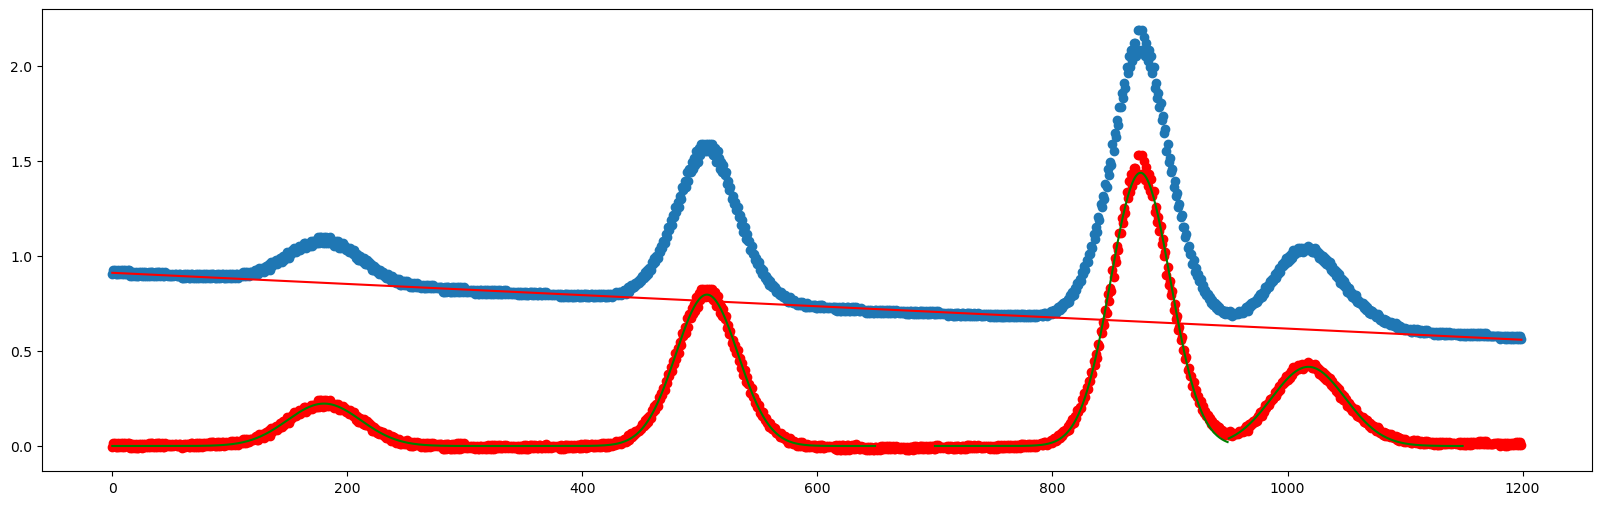

In [ ]:

IvsP = np.loadtxt("/media/jacklook/JJ_memory/NewFile12.csv", skiprows=2,delimiter=",",dtype=str)
#IvsP1 = np.loadtxt("/media/jacklook/JJ_memory/NewFile11.csv", skiprows=2,delimiter=",",dtype=str)
#IvSP2 = np.loadtxt("/media/jacklook/JJ_memory/NewFile3.csv", skiprows=2,delimiter=",",dtype=str)
#IvSP3 = np.loadtxt("/media/jacklook/JJ_memory/NewFile2.csv", skiprows=2,delimiter=",",dtype=str)
#V2 = np.asarray(IvSP2[:,1], dtype=float)
#V3 = np.asarray(IvSP3[:,1], dtype=float)
V0 = np.asarray(IvsP[:,1], dtype=float)
t0 = np.asarray(IvsP[:,0], dtype=float) 
#V1 = np.asarray(IvsP1[:,1], dtype=float)


figure, ax = plt.subplots()
figure.set_size_inches(20, 6)
V = np.asarray(IvsP[:,1], dtype=float)
#V2 = np.asarray(IvsP1[:,1], dtype=float)

print('mean of signal is', np.mean(V))
print('std of signal is', np.std(V))
print('max of signal is', np.max(V))
print('min of signal is', np.min(V))
print('peak to peak of signal is', np.max(V)-np.min(V))

#plt.scatter(np.arange(len(V)), V1-0.004)
#plt.scatter(np.arange(len(V)), V0)
plt.scatter(t0, -np.log(V0+0.5))
#plt.scatter(np.arange(len(V)), np.log(V0+0.004-V1))
#plt.ylim(-10,0)
#plt.scatter(np.arange(len(V)), np.log(V2-V3))
# isolate data from 0 to 100, from 250 to 350, from 600 to 750 and from 1150 to 1200
t_start =[0, 250, 600, 1150]
t_end = [100, 350, 750, 1200]
V_linear = np.array([])
t_linear = np.array([])
for i in range(4):
    V_linear = np.concatenate((V_linear, -np.log(V0[int(t_start[i]):int(t_end[i])]+0.5)))
    t_linear = np.concatenate((t_linear, t0[int(t_start[i]):int(t_end[i])]))
print('V_linear is', V_linear)
print('t_linear is', t_linear)
# now do linear fit on all V_linear
fit = np.polyfit(t_linear, V_linear, 1)
print('fit is', fit)
# now plot the linear fit
plt.plot(t_linear, fit[0]*t_linear+fit[1], 'r')

# now plot the original plot taking away the linear fit
plt.scatter(t0, -np.log(V0+0.5)-(fit[0]*t0+fit[1]), c='r')
# now fit a gaussian function in the first 350 data points
t_fit = t0[:350]
V_fit = -np.log(V0[:350]+0.5)-(fit[0]*t0[:350]+fit[1])
popt, pcov = curve_fit(Gauss, t_fit, V_fit, p0=[1, 1, 100])
print('popt is', popt)
plt.plot(t_fit, Gauss(t_fit, *popt), 'g')

# now fit gaussian from 350 to 650
t_fit = t0[350:650]
V_fit = -np.log(V0[350:650]+0.5)-(fit[0]*t0[350:650]+fit[1])
popt, pcov = curve_fit(Gauss, t_fit, V_fit, p0=[1, 1, 500])
print('popt is', popt)
plt.plot(t_fit, Gauss(t_fit, *popt), 'g')

# now fit gaussian from 700 to 950
t_fit = t0[700:950]
V_fit = -np.log(V0[700:950]+0.5)-(fit[0]*t0[700:950]+fit[1])
popt, pcov = curve_fit(Gauss, t_fit, V_fit, p0=[1, 1, 800])
print('popt is', popt)
plt.plot(t_fit, Gauss(t_fit, *popt), 'g')

# now fit gaussian from 950 to 1150
t_fit = t0[950:1150]
V_fit = -np.log(V0[950:1150]+0.5)-(fit[0]*t0[950:1150]+fit[1])
popt, pcov = curve_fit(Gauss, t_fit, V_fit, p0=[1, 1, 1050])
print('popt is', popt)
plt.plot(t_fit, Gauss(t_fit, *popt), 'g')

# now rescale x axis with first and last gaussian centers corresponding to 0 and 6.8
t_new = 




In [ ]:
#plt.scatter(np.arange(len(V1)), V1)
V_diff = V[1:]-V[:-1]
V_div = np.amin(V_diff[V_diff>0])
print(V_div)
print(0.001*10/256)
n = 50
new_V = np.zeros(len(V)-n)
for i in range(len(new_V)):
    new_V[i] = np.mean(V[i:i+n])
plt.plot(np.arange(len(new_V))/100, new_V)


Vdiv 0.00399999999999999 0.009999999999999787
[ 0.   -0.01  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.   -0.01  0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.01  0.    0.
  0.    0.    0.    0.  ]
Vpp 0.08 0.54
0.108 2.14
0.000421875 0.008359375


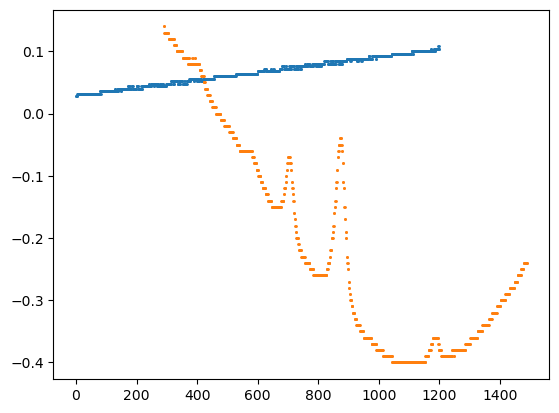

In [ ]:
IvsP = np.loadtxt("Data/Old/NewFile19.csv", skiprows=2,delimiter=",",dtype=str)
V = np.asarray(IvsP[:,1], dtype=float)
plt.scatter(np.arange(len(V)), V,s=1)
IvsP = np.loadtxt("Data/NewFile18.csv", skiprows=2,delimiter=",",dtype=str)
V1 = np.asarray(IvsP[:,1], dtype=float)
plt.scatter(np.arange(len(V1))+290, V1-2,s=1)
V_diff = V[1:]-V[:-1]
V_div = np.amin(V_diff[V_diff>0])
V1_diff = V1[1:]-V1[:-1]
V1_div = np.amin(V1_diff[V1_diff>0])
print("Vdiv",V_div, V1_div)
print(V1_diff[:40])
V_pp = np.amax(V)-np.amin(V)
V1_pp = np.amax(V1)-np.amin(V1)
print("Vpp",V_pp, V1_pp)
V_max = np.amax(V)
V1_max = np.amax(V1)
print(V_max, V1_max)
print(V_max/256, V1_max/256)



[1.77 1.77 1.77 1.77 1.77 1.77 1.78 1.78 1.78 1.78 1.78 1.78 1.78 1.78
 1.78 1.78 1.78 1.78 1.79 1.79 1.79 1.79 1.79 1.79 1.79 1.79 1.79 1.79
 1.79 1.79 1.8  1.8  1.8  1.8  1.8  1.8  1.8  1.8  1.8  1.8  1.8  1.8
 1.8  1.8  1.81 1.81 1.81 1.81 1.81 1.81 1.82 1.82 1.82 1.82 1.82 1.82
 1.82 1.82 1.82 1.82 1.83 1.83 1.83 1.83 1.83 1.83 1.83 1.83 1.84 1.84
 1.84 1.84 1.84 1.84 1.84 1.84 1.85 1.85 1.85 1.85 1.85 1.85 1.86 1.86
 1.86 1.86 1.86 1.86 1.86 1.86 1.86 1.86 1.87 1.87 1.87 1.87 1.87 1.87
 1.87 1.87]


0.2048

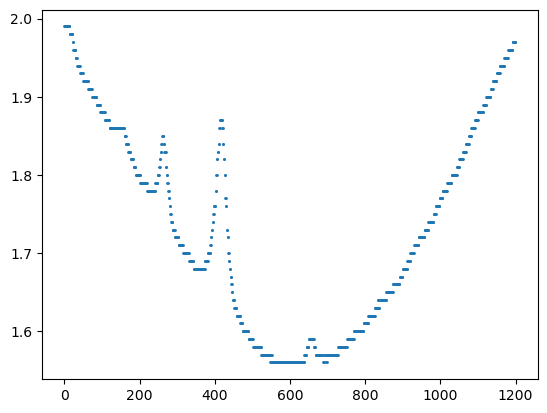

In [ ]:
IvsP = np.loadtxt("Data/NewFile2.csv", skiprows=2,delimiter=",",dtype=str)
V = np.asarray(IvsP[:,1], dtype=float)
plt.scatter(np.arange(len(V)), V,s=1)
print(V[1000:1100])
0.0008*256

In [ ]:
def find_extremes_ramp_2(x):
    t = np.arange(0,len(x))
    step = 5
    width = 25
    l_d = int((len(x)-width)/step)+1
    d_arr = np.zeros(l_d)
    pos_arr = np.zeros(l_d)
    avg_arr = np.zeros(l_d)
    for i in range(l_d):
        lfit = np.polyfit(t[i*step:i*step+width],x[i*step:i*step+width],1)
        d_arr[i] = lfit[0]
        pos_arr[i] = i*step + width/2
        avg_arr[i] = np.mean(x[i*step:i*step+width])
    # find the two values of d_arr that are closest to zero
    idx = np.argsort(abs(d_arr))
    cnt = 0
    start = 0
    end = 0
    bl_start_found = False
    bl_end_found = False
    found_all = False
    while (cnt<len(idx)) and (found_all == False):
        i = int(idx[cnt])
        if (i<len(idx)/2) and (bl_start_found == False):
            start = pos_arr[i]
            bl_start_found = True
        if (i>len(idx)/2) and (bl_end_found == False):
            end = pos_arr[i]
            bl_end_found = True
        if (bl_start_found == True) and (bl_end_found == True):
            found_all = True
        cnt+=1
    start1 = pos_arr[np.argmin(avg_arr)]
    end1 = pos_arr[np.argmax(avg_arr)]
    print(start,end)
    print(start1,end1)
    return start,end